In [1]:
import pandas as pd
import numpy as np
import random

import quantlib
import quantlib.indicators_cal as indicators_cal
import quantlib.diagnostics_utils as diagnostics_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_instruments_from_df(df):
    instruments = []
    for col in df.columns:
        inst = col.split(" ")[0]
        if "USD" in inst and inst not in instruments:
            instruments.append(inst)
    return instruments

origin_df = pd.read_excel("../crypto_historical_4h.xlsx", engine="openpyxl", index_col='open_time')

In [23]:
periods = [10, 15, 18, 20, 25, 30, 35, 40, 45]
look_ahead = 15
IGNORES = 5 # We do not want to count the closest momentum for possible reversion

instruments = get_instruments_from_df(origin_df)
remove_instruments = []

df = origin_df.copy()
for inst in instruments:
    for p in periods:
        df["{} {} ret".format(inst, p)] = df["{} close".format(inst)].shift(IGNORES) / df["{} close".format(inst)].shift(p+IGNORES) - 1
        df["{} {} fwd ret".format(inst, p)] = df["{} close".format(inst)].shift(-p) / df["{} close".format(inst)] - 1

for inst in instruments:
    if df[f"{inst} {periods[0]} fwd ret"].iloc[0] == 0:
        remove_instruments.append(inst)
    if df[f"{inst} active"].iloc[-2] == False:
        print (inst)
        remove_instruments.append(inst)

df_cols = [col for col in df.columns if col.split(" ")[0] not in remove_instruments]
df = df[df_cols]

COMPUSDT
SRMUSDT
CVCUSDT
BTSUSDT
BTCSTUSDT
SCUSDT
TLMUSDT
RAYUSDT
FTTUSDT
ANCBUSD
AUCTIONBUSD


In [24]:
target_instruments = [x for x in instruments if x not in remove_instruments]

def set_rank_df(periods, index, rank_df, target_df, instruments):
    for inst in instruments:
        for p in periods:
            rank_df.loc[index, f"{inst} {p} ret"] = target_df.loc[index, f"{inst} {p} ret"]
            rank_df.loc[index, f"{inst} {p} fwd ret"] = target_df.loc[index, f"{inst} {p} fwd ret"]
            rank_df.loc[index, f"{inst} % ret vol"] = target_df.loc[index, f"{inst} % ret vol"]
    return rank_df

def get_momentum_rank(df, rebalance_period=10):
    instruments = get_instruments_from_df(df)
    target_df = df.copy().reset_index()
    rank_df = pd.DataFrame()
    for i in target_df.index:
        if i % rebalance_period == 1 and i != 1:
            rank_df = set_rank_df(periods, i, rank_df, target_df, instruments)

    rank_df = rank_df.dropna(axis=0).reset_index(drop=True)
    return rank_df

rank_df = get_momentum_rank(df, look_ahead)

In [25]:
rank_df

,BTCUSDT 10 ret,BTCUSDT 10 fwd ret,BTCUSDT % ret vol,BTCUSDT 15 ret,BTCUSDT 15 fwd ret,BTCUSDT 18 ret,BTCUSDT 18 fwd ret,BTCUSDT 20 ret,BTCUSDT 20 fwd ret,BTCUSDT 25 ret,...,OPUSDT 25 ret,OPUSDT 25 fwd ret,OPUSDT 30 ret,OPUSDT 30 fwd ret,OPUSDT 35 ret,OPUSDT 35 fwd ret,OPUSDT 40 ret,OPUSDT 40 fwd ret,OPUSDT 45 ret,OPUSDT 45 fwd ret
0,-0.036540,-0.032527,0.013302,-0.033549,-0.025293,-0.035145,0.005029,-0.001346,0.004956,0.026280,...,-0.017508,-0.069956,0.017949,-0.001927,-0.040151,0.069956,0.030742,0.350357,0.023225,0.384660
1,-0.032527,0.042129,0.012427,-0.048950,0.060206,-0.068703,0.074004,-0.068375,0.058890,-0.083702,...,-0.194590,0.525582,-0.186067,0.564337,-0.183764,0.592641,-0.149466,0.490965,-0.118770,0.693229
2,0.042129,0.044642,0.014075,0.049922,0.027223,0.077638,0.104190,0.047603,0.106187,0.015771,...,-0.069956,0.322263,-0.094729,0.501641,-0.115793,0.570960,-0.157766,0.651091,-0.148854,0.781618
3,0.044642,0.067115,0.019263,0.062762,0.065806,0.065777,0.061955,0.074199,0.070112,0.107536,...,0.525582,0.190118,0.518310,0.284203,0.496583,0.196103,0.350357,0.106193,0.314388,0.076409
4,0.067115,-0.041681,0.023000,0.049322,-0.021584,0.116719,-0.021468,0.097528,-0.057560,0.096166,...,0.322263,0.021988,0.418981,-0.005529,0.382596,0.080622,0.490965,0.417770,0.483857,1.115340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.005498,-0.046324,0.006852,0.009752,-0.044824,-0.008619,-0.038842,-0.008165,-0.032525,-0.007272,...,-0.001432,-0.191950,0.004689,-0.178933,0.029943,-0.103571,0.239165,0.057244,0.384828,0.080351
86,-0.046324,-0.002619,0.008048,-0.066264,0.004956,-0.069531,0.025129,-0.055907,0.020150,-0.061130,...,-0.185469,0.161604,-0.181242,0.186993,-0.192364,0.128550,-0.196424,0.125459,-0.191499,0.126860
87,-0.002619,0.118231,0.005189,-0.001050,0.143342,-0.006016,0.086218,-0.010157,0.108985,-0.047325,...,-0.191950,0.247579,-0.281823,0.249132,-0.272116,0.197368,-0.273074,0.191749,-0.269301,0.136422
88,0.118231,-0.014205,0.012260,0.126723,-0.012151,0.117656,-0.014731,0.109487,-0.018654,0.123773,...,0.161604,-0.094271,0.167668,-0.136319,0.169897,-0.132500,0.057244,-0.044861,-0.060345,0.086875


In [26]:
look_back = 40
k=20

portfolio_df = pd.DataFrame(index=rank_df.index)
target_ret_cols = [f"{inst} {look_back} ret" for inst in target_instruments]
target_fwd_ret_cols = [f"{inst} {look_ahead} fwd ret" for inst in target_instruments]
target_ret_vol_cols = [f"{inst} % ret vol" for inst in target_instruments]


for i in rank_df.index:
    rank = pd.qcut(rank_df.loc[i, target_ret_cols], k, labels=False)
    for col in target_ret_cols:
        portfolio_df.loc[i, col] = int(rank[col])
    for col in target_fwd_ret_cols:
        portfolio_df.loc[i, col] = rank_df.loc[i, col]


def lookup_ret(index, portfolio_df, rank_portfolio):
    fwd_ret_cols = []
    ret_cols = []
    ret_vol_cols = []
    for inst in rank_portfolio:
        for col in target_fwd_ret_cols:
            if inst in col: fwd_ret_cols.append(col)
        for col in target_ret_cols:
            if inst in col: ret_cols.append(col)
        for col in target_ret_vol_cols:
            if inst in col: ret_vol_cols.append(col)
    
    ret_vols = 1 / (rank_df.loc[index, ret_vol_cols] + 0.001)
    ret_vols_percent = ret_vols / ret_vols.sum()
    #inst_fwd_ret = rank_df.loc[index, fwd_ret_cols].mean()
    inst_fwd_ret = np.average(rank_df.loc[index, fwd_ret_cols], weights=ret_vols_percent)
    inst_ret = rank_df.loc[index, ret_cols].mean()
    inst_ret_vol = rank_df.loc[index, ret_vol_cols].mean()
    return inst_fwd_ret, inst_ret, inst_ret_vol
        

rank_cols = [i for i in range(k)]
result_df = pd.DataFrame(index=portfolio_df.index, columns=rank_cols)
for i in portfolio_df.index:
    result_df.loc[i, rank_cols] = [[] for _ in range(k)]
    for col in target_ret_cols:
        inst = col.split(" ")[0]
        rank = portfolio_df.loc[i, col]
        result_df.loc[i, rank].append(inst)

for i in result_df.index:
    for rank in result_df[rank_cols]:
        rank_portfolio = result_df.loc[i, rank]
        inst_fwd_ret, inst_ret, inst_ret_vol = lookup_ret(i, portfolio_df, rank_portfolio)
        result_df.loc[i, f"rank {rank} fwd ret"] = inst_fwd_ret
        result_df.loc[i, f"rank {rank} ret"] = inst_ret
        result_df.loc[i, f"rank {rank} ret vol"] = inst_ret_vol


fwd_ret = result_df[[f"rank {rank} fwd ret" for rank in range(k)]].mean().reset_index(drop=True)
ret = result_df[[f"rank {rank} ret" for rank in range(k)]].mean().reset_index(drop=True)
compare_df = pd.concat({f"{look_back} Return": ret, f"{look_ahead} Forward Return": fwd_ret},
                    axis=1)
compare_df = compare_df.apply(lambda x: x*100)

compare_df



,40 Return,15 Forward Return
0,-12.361695,-0.146635
1,-7.739870,0.498246
2,-6.148667,0.590910
3,-4.947678,0.592675
4,-4.177724,0.366994
5,-3.397430,0.742852
6,-2.803452,0.538073
7,-2.195283,0.379796
8,-1.563845,0.358788
9,-1.055159,0.885166


Sharpe ratio: 2.853596899382068
Max drawdown: -32.322862700038776%


<Axes: >

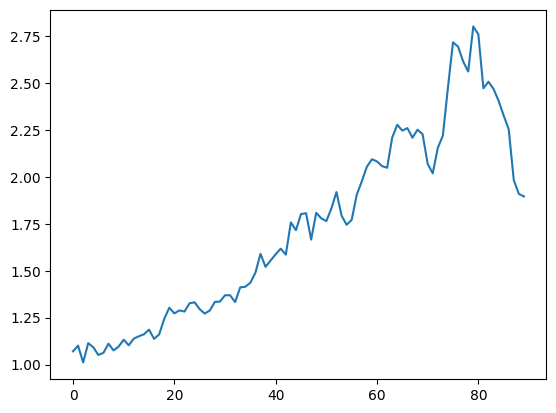

In [29]:
# long-short
result_df["portfolio ret"] = result_df[f"rank {k-2} fwd ret"] - result_df["rank 0 fwd ret"]
sharpe = result_df["portfolio ret"].mean() / result_df["portfolio ret"].std() * np.sqrt(253)

result_df["portfolio ret"] = (1+result_df["portfolio ret"]).cumprod()
result_df["drawdown"] = result_df["portfolio ret"] / result_df["portfolio ret"].cummax() - 1
max_drawdown = result_df["drawdown"].min()*100
print (f"Sharpe ratio: {sharpe}")
print (f"Max drawdown: {max_drawdown}%")
result_df["portfolio ret"].plot()

Sharpe ratio: 1.5440675657521765
Max drawdown: -33.265654825139734%


<Axes: >

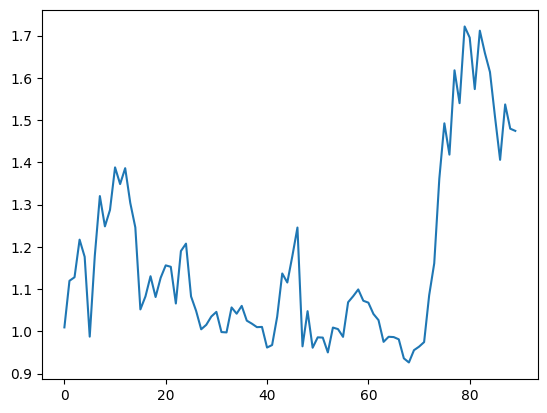

In [31]:
# long only
result_df["portfolio ret"] = result_df[f"rank {k-2} fwd ret"]
sharpe = result_df["portfolio ret"].mean() / result_df["portfolio ret"].std() * np.sqrt(253)

result_df["portfolio ret"] = (1+result_df["portfolio ret"]).cumprod()
result_df["drawdown"] = result_df["portfolio ret"] / result_df["portfolio ret"].cummax() - 1
max_drawdown = result_df["drawdown"].min()*100
print (f"Sharpe ratio: {sharpe}")
print (f"Max drawdown: {max_drawdown}%")
result_df["portfolio ret"].plot()

In [50]:
# IGNORES = 5
# look back, look ahead = 50, 50
# k=12


"""
4h: lookback=40, lookahead=20, k=20, IGNORE=1
sharpe: 5.64
"""
result_df

,0,1,2,3,4,5,6,7,8,9,...,rank 17 ret,rank 17 ret vol,rank 18 fwd ret,rank 18 ret,rank 18 ret vol,rank 19 fwd ret,rank 19 ret,rank 19 ret vol,portfolio ret,drawdown
0,"[STORJUSDT, LITUSDT, SFPUSDT, OGNUSDT, GTCUSDT...","[BATUSDT, 1INCHUSDT, RVNUSDT, IOTXUSDT, ATAUSD...","[DOGEUSDT, FTMUSDT, BELUSDT, GALAUSDT, LPTUSDT...","[ZRXUSDT, SXPUSDT, ZENUSDT, SKLUSDT, C98USDT, ...","[MKRUSDT, BALUSDT, RSRUSDT, MANAUSDT, DENTUSDT...","[ONTUSDT, KAVAUSDT, YFIUSDT, MTLUSDT, DUSKUSDT...","[ICXUSDT, ENJUSDT, ANKRUSDT, CHRUSDT, ALICEUSD...","[XLMUSDT, THETAUSDT, OMGUSDT, WAVESUSDT, TOMOU...","[ETCUSDT, ADAUSDT, QTUMUSDT, LRCUSDT, LINAUSDT...","[NEOUSDT, ZILUSDT, DOTUSDT, FILUSDT, MASKUSDT,...",...,0.024304,0.026047,0.055809,0.079379,0.026033,0.093860,0.155526,0.031838,0.991867,0.000000
1,"[LITUSDT, UNFIUSDT, OGNUSDT, BTCDOMUSDT, ARPAU...","[XTZUSDT, ONTUSDT, BELUSDT, CTKUSDT, MASKUSDT,...","[DOGEUSDT, KAVAUSDT, BANDUSDT, STORJUSDT, CHZU...","[IOTAUSDT, BATUSDT, SXPUSDT, HNTUSDT, ALICEUSD...","[ZILUSDT, ANKRUSDT, MTLUSDT, BAKEUSDT, C98USDT...","[XLMUSDT, ADAUSDT, ATOMUSDT, ZRXUSDT, ICXUSDT,...","[TRXUSDT, VETUSDT, THETAUSDT, OMGUSDT, BLZUSDT...","[LINKUSDT, IOSTUSDT, WAVESUSDT, ONEUSDT, IOTXU...","[BTCUSDT, EOSUSDT, FTMUSDT, ZENUSDT, ATAUSDT, ...","[ZECUSDT, COMPUSDT, TOMOUSDT, XEMUSDT, HBARUSD...",...,0.209377,0.025215,0.033642,0.272019,0.029973,0.046974,0.317965,0.031823,1.059144,0.000000
2,"[EGLDUSDT, RSRUSDT, BELUSDT, CTKUSDT, UNFIUSDT...","[RLCUSDT, SUSHIUSDT, UNIUSDT, OGNUSDT, ARUSDT,...","[TRXUSDT, BATUSDT, STORJUSDT, AAVEUSDT, STMXUS...","[IOSTUSDT, COMPUSDT, FILUSDT, CHZUSDT, LITUSDT...","[XLMUSDT, ALGOUSDT, KAVAUSDT, BAKEUSDT, MASKUS...","[EOSUSDT, XTZUSDT, THETAUSDT, ICXUSDT, HNTUSDT...","[XRPUSDT, ZECUSDT, ZILUSDT, RENUSDT, HOTUSDT, ...","[OMGUSDT, SNXUSDT, DEFIUSDT, OCEANUSDT, GALAUS...","[DASHUSDT, ONTUSDT, KNCUSDT, ZRXUSDT, MKRUSDT,...","[BANDUSDT, YFIUSDT, ZENUSDT, GRTUSDT, LINAUSDT...",...,0.214133,0.034863,-0.087307,0.234303,0.039385,-0.071625,0.357393,0.039058,1.030845,-0.026719
3,"[SUSHIUSDT, EGLDUSDT, RSRUSDT, NKNUSDT, BAKEUS...","[ZECUSDT, RLCUSDT, LRCUSDT, RVNUSDT, GTCUSDT, ...","[RENUSDT, AAVEUSDT, BELUSDT, MASKUSDT, IMXUSDT...","[BATUSDT, COMPUSDT, STORJUSDT, GRTUSDT, ARPAUS...","[TRXUSDT, IOSTUSDT, FILUSDT, CTKUSDT, SKLUSDT,...","[ICXUSDT, CHZUSDT, BTCDOMUSDT, C98USDT, ROSEUS...","[ALGOUSDT, MKRUSDT, SOLUSDT, OCEANUSDT, ZENUSD...","[HNTUSDT, MATICUSDT, STMXUSDT, HOTUSDT, OGNUSD...","[XRPUSDT, ZRXUSDT, KAVAUSDT, DOTUSDT, 1INCHUSD...","[ZILUSDT, KNCUSDT, UNIUSDT, ATAUSDT, 1000XECUS...",...,0.084370,0.025274,0.113047,0.117110,0.027202,0.100156,0.218833,0.036544,1.074101,0.000000
4,"[ATOMUSDT, FLMUSDT, ONEUSDT, MTLUSDT, IOTXUSDT...","[SOLUSDT, TOMOUSDT, RENUSDT, RSRUSDT, LRCUSDT,...","[AVAXUSDT, HNTUSDT, SANDUSDT, REEFUSDT, CTSIUS...","[ALGOUSDT, RLCUSDT, RUNEUSDT, SKLUSDT, COTIUSD...","[CRVUSDT, NEARUSDT, ALPHAUSDT, ZENUSDT, NKNUSD...","[ENJUSDT, LINAUSDT, ARUSDT, ARPAUSDT, ANTUSDT,...","[COMPUSDT, DOGEUSDT, ANKRUSDT, BTCDOMUSDT, CEL...","[EGLDUSDT, BELUSDT, BAKEUSDT, LPTUSDT, BNXUSDT...","[XTZUSDT, ZILUSDT, STORJUSDT, HBARUSDT, HOTUSD...","[XLMUSDT, BATUSDT, SXPUSDT, WAVESUSDT, ICXUSDT...",...,0.082397,0.025099,0.129847,0.148677,0.031311,0.134983,0.320259,0.038600,1.103808,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,"[KNCUSDT, KAVAUSDT, MKRUSDT, SOLUSDT, HNTUSDT,...","[ETHUSDT, ETCUSDT, ZECUSDT, BALUSDT, ENJUSDT, ...","[LTCUSDT, DASHUSDT, SNXUSDT, ZENUSDT, CHZUSDT,...","[XRPUSDT, TRXUSDT, ATOMUSDT, DOGEUSDT, CRVUSDT...","[XMRUSDT, SUSHIUSDT, UNIUSDT, AAVEUSDT, GALAUS...","[BTCUSDT, BATUSDT, ZILUSDT, DOTUSDT, SKLUSDT, ...","[XLMUSDT, XTZUSDT, NEOUSDT, RUNEUSDT, EGLDUSDT...","[LINKUSDT, ADAUSDT, ALGOUSDT, DEFIUSDT, NEARUS...","[BCHUSDT, ONTUSDT, YFIUSDT, ARUSDT, IMXUSDT, O...","[COMPUSDT, BANDUSDT, RLCUSDT, CTKUSDT, 1INCHUS...",...,0.171900,0.026827,-0.077796,0.248089,0.034890,-0.069549,0.463511,0.046466,2.003059,-0.070960
60,"[KNCUSDT, SNXUSDT, ICXUSDT, NEARUSDT, CHZ

In [30]:
import pandas as pd

df = pd.read_excel("../crypto_historical_4h.xlsx", engine="openpyxl", index_col='open_time')

look_back = 40
look_ahead = 20
IGNORES = 0 # We do not want to count the closest momentum for possible reversion


In [43]:
def get_instruments_from_df(df):
    instruments = []
    for col in df.columns:
        inst = col.split(" ")[0]
        if "USD" in inst and inst not in instruments:
            instruments.append(inst)
    return instruments

instruments = get_instruments_from_df(df)
ret_cols = []

for inst in instruments:
    ret_col_name = "{} {} ret".format(inst, look_back)
    ret_cols.append(ret_col_name)
    df["{} {} ret".format(inst, look_back)] = df["{} close".format(inst)].shift(IGNORES) / df["{} close".format(inst)].shift(look_back+IGNORES) - 1

last = df[ret_cols].tail(1).reset_index(drop=True)
for col in last.columns:
    if last.loc[0, col] == 0:
        ret_cols.remove(col)
rank = pd.qcut(last.loc[0, ret_cols], 20, labels=False)
last

,BTCUSDT 40 ret,ETHUSDT 40 ret,BCHUSDT 40 ret,XRPUSDT 40 ret,EOSUSDT 40 ret,LTCUSDT 40 ret,TRXUSDT 40 ret,ETCUSDT 40 ret,LINKUSDT 40 ret,XLMUSDT 40 ret,...,HOOKUSDT 40 ret,MAGICUSDT 40 ret,TUSDT 40 ret,RNDRUSDT 40 ret,HIGHUSDT 40 ret,MINAUSDT 40 ret,ASTRUSDT 40 ret,AGIXUSDT 40 ret,GMXUSDT 40 ret,CFXUSDT 40 ret
0,0.14464,0.144934,0.176087,0.070787,0.236275,0.077025,0.096128,0.138361,0.234618,0.100654,...,0.135678,0.302268,0.188522,0.170271,0.279631,0.097142,0.2322,-0.148812,-0.013008,NaN


In [44]:
long_list, short_list = [], []
for col in ret_cols:
    symbol = col.split(" ")[0]
    if rank[col] == 0:
        short_list.append(symbol)
    elif rank[col] == 19:
        long_list.append(symbol)

print ("Long list: ", long_list)
print ("Short list: ", short_list)

Long list:  ['IOSTUSDT', 'BLZUSDT', 'FILUSDT', 'DENTUSDT', 'MTLUSDT', 'NKNUSDT', 'KLAYUSDT', 'STGUSDT']
Short list:  ['MKRUSDT', 'BTCDOMUSDT', 'FOOTBALLUSDT', '1000LUNCUSDT', 'LUNA2USDT', 'APTUSDT', 'AGIXUSDT', 'GMXUSDT']


In [39]:
from brokerage.binance.TradeClient import TradeClient

client = TradeClient()
for symbol in long_list:
    pass

open_time
2023-02-20 08:00:00    0.0
Name: FTTUSDT 40 ret, dtype: float64